In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, r2_score
import joblib
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import statsmodels.api as sm

In [2]:
# Defining dfs
df=pd.read_csv("vcalibration_input_final.csv")
X = df.drop(columns=['Count_vol'])
y = df['Count_vol']  

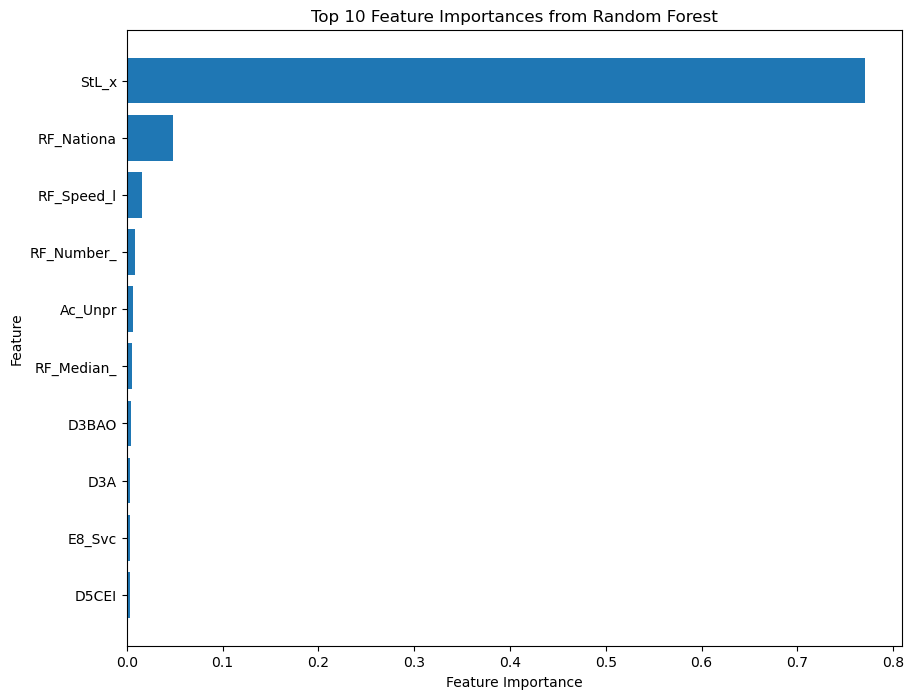

In [3]:
# Initial training for selection purposes
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

# Fitting model
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,y_train)

# Feature importances
features = X.columns
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])

# Plotting top 10 features
top_n = 10                   # Selecting the top 20 features
top_features = f_i[-top_n:]  

plt.figure(figsize=(10, 8))  
plt.barh([x[0] for x in top_features], [x[1] for x in top_features])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances from Random Forest')
plt.show()

In [4]:
print(top_features)

[('D5CEI', 0.0033789933569351675), ('E8_Svc', 0.0036535032628424776), ('D3A', 0.0037454157747537956), ('D3BAO', 0.00398354236165281), ('RF_Median_', 0.004953380945339853), ('Ac_Unpr', 0.006238943590611087), ('RF_Number_', 0.009076920765434256), ('RF_Speed_l', 0.016152276496650644), ('RF_Nationa', 0.048053121686871376), ('StL_x', 0.7704946818518846)]


In [5]:
# This part of code was disregarded (only one variavle is selected)

# Selecting features using Recursive Feature Elimination with Cross-Validation (RFECV)
# rfe = RFECV(rf,cv=5,scoring="neg_mean_squared_error")
# rfe.fit(X_train,y_train)

# Selected features
# selected_features = np.array(features)[rfe.get_support()]

# print(selected_features)

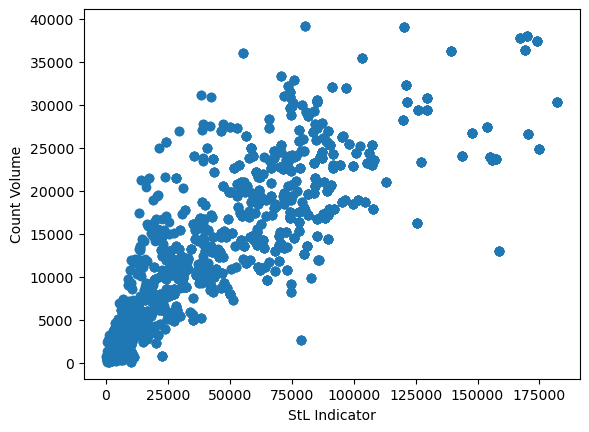

In [6]:
# Plotting Count_vol vs. StL_x
import matplotlib.pyplot as plt

y_plot = df['Count_vol']  
x_plot = df['StL_x']

plt.scatter(x_plot, y_plot)
plt.xlabel("StL Indicator")
plt.ylabel("Count Volume")
plt.show()

In [7]:
# Random forest model

x_vars = [feature[0] for feature in top_features]
X = df[x_vars]
y = df['Count_vol']  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=99)

# Fitting the model
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

# Calculating r2 for both train and test sets
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
r2_trn = r2_score(y_train, y_pred_train)
r2_tst = r2_score(y_test, y_pred_test)
print("R-squared score for training data:", r2_trn)
print("R-squared score for test data:", r2_tst)

# Calculating RMSE
mse = mean_squared_error(y_test, y_pred_test)
rmse = mse**.5
print("MSE for test data: ", mse)
print("RMSE for test data: ", rmse)

R-squared score for training data: 0.9925970596032381
R-squared score for test data: 0.9469630476341948
MSE for test data:  4470352.927404452
RMSE for test data:  2114.320914006304


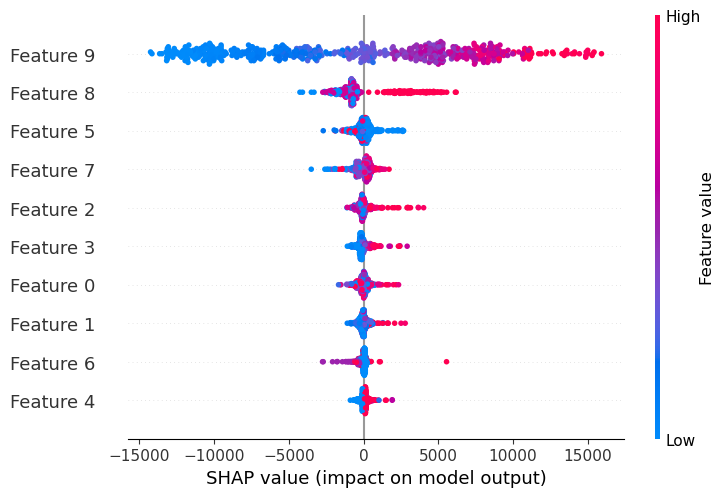

In [9]:
# Calculating SHAP values for pedestrian model

import shap

# Creating SHAP explainer
explainer = shap.TreeExplainer(clf)

# Calculating SHAP values for all test instances
shap_values = explainer(X_test, check_additivity=False)

# Plotting the beeswarm plot for all instances
shap.plots.beeswarm(shap_values)

In [13]:
# Now predicting volumes for the entire StL network
import pandas as pd
from simpledbf import Dbf5
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# Reading the DBF file into a DataFrame
dbf = Dbf5('Veh_Network_StL_v7.3_RF_CR_ND_NS.dbf')
StL_Predict = dbf.to_dataframe()

# Looping through the StL indicators and predicting a volume for each day part/day
for i in range(8):
    for j in range(1, 6):
        # Skip the StL_6_5 column
        if i == 6 and j == 5:
            continue
        # Renaming the column to StL_x for model use
        StL_Predict['StL_x'] = StL_Predict[f'StL_{i}_{j}']
        
        # Defining the features that enter the model
        x_vars = [feature[0] for feature in top_features]
        X_predict = StL_Predict[x_vars]
        
        # Checking for NaNs in x_vars and filtering them out
        non_nan_rows = X_predict.dropna().index
        X_predict_non_nan = X_predict.loc[non_nan_rows]
        
        # Scaling the x's using the same scaler
        X_predict_scaled = scaler.transform(X_predict_non_nan)
        
        # Predicting volumes using our trained model
        y_predict = clf.predict(X_predict_scaled)
        
        # Add predictions to the DataFrame, only for non-NaN rows
        StL_Predict.loc[non_nan_rows, f'RF_Vol_{i}_{j}'] = y_predict

# Save the DataFrame to a CSV file
StL_Predict.to_csv('Veh_Network_StL_v7.3_RF_CR_ND_NS_Predicted.csv', index=False)

In [8]:
# This code generates the p-values for all the variables

# Defining dfs
df=pd.read_csv("calibration_input_final.csv")
X = df.drop(columns=['Count_vol'])
y = df['Count_vol']  

# Adding a constant
X = sm.add_constant(X)

# Fitting the OLS regression model
model = sm.OLS(y, X).fit()

# Extracting and sorting the p-values < 0.05
filtered_p_values = model.pvalues[model.pvalues < 0.05]
sorted_filtered_p_values = filtered_p_values.sort_values()

# Printing the sorted p-values less than 0.05
pd.set_option('display.max_rows', None)
print("Variables with p-values less than 0.05:")
print(sorted_filtered_p_values)

Variables with p-values less than 0.05:
StL_x         0.000000e+00
RF_Speed_l    3.335057e-36
RF_Nationa    9.652209e-32
RF_Median_    2.210480e-07
Ac_Water      2.026540e-04
Ac_Land       2.026540e-04
Ac_Total      2.026540e-04
CountHU       2.450790e-04
logd3aao      1.676501e-03
D4B050        1.995183e-03
D4B025        3.909772e-03
D1C8_PUB      4.500960e-03
D1C8_OFF      4.500964e-03
C_R_White     7.942222e-03
VMT_tot_mi    8.119755e-03
C_R_Medwag    8.842932e-03
D1C8_HLTH     9.020638e-03
D1C8_SVC      9.020641e-03
D1C8_ED       9.020648e-03
D5AE          9.036720e-03
D5CEI         9.072374e-03
UPTpercap     1.151977e-02
D3AAO         1.350372e-02
D3APO         1.350372e-02
D3AMM         1.350372e-02
D3A           1.350372e-02
D5DR          1.455354e-02
Workers_1     1.645254e-02
E8_Ent        1.839278e-02
logd1c        1.840256e-02
D1C5_IND      1.951268e-02
D1C5_RET      1.951270e-02
D1C8_ENT      1.951276e-02
D1C5_ENT      1.951293e-02
D1C8_IND      1.951295e-02
D1C8_RET      1

In [10]:
# Selecting features for the Poisson and Negative Binomial models using Elastic Net (tuning alpha using CV)

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

df=pd.read_csv("calibration_input_final.csv")
Xen = df.drop(columns=['Count_vol'])
y = df['Count_vol']  

# Standardizing X (y is centralized by default in ElasticNetCV)
scaler = StandardScaler()
Xen_scaled = scaler.fit_transform(Xen)

# Defining l1_ratios (L1/L2 penalty split) for tuning since only alpha is tuned in this class
l1_ratios = [0.99999] # Least RMSE is at 1 (only l1 regularization), using 0.99999 to maintain slight l2 reg for stability and multicollinearity 
EN = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=99, max_iter=100000)
EN.fit(Xen_scaled, y)

# Now printing the coeffs
print("lambda: ", EN.alpha_)
print("l1_ratio: ", EN.l1_ratio_)

# Identifying the selected features
coeffs = EN.coef_ 
features = Xen.columns
selected = features[coeffs != 0]
print("Selected features:", selected.tolist())

# Calculate and print RMSE for each l1_ratio
mse_mean = EN.mse_path_.mean(axis=1)  # mean squared error for each alpha and l1_ratio
rmse = np.sqrt(mse_mean)

for i, l1_ratio in enumerate(l1_ratios):
    print(f"RMSE for l1_ratio {l1_ratio}: {rmse[i]}")

lambda:  24.817229101364582
l1_ratio:  0.99999
Selected features: ['RF_Number_', 'RF_Median_', 'RF_Nationa', 'RF_Speed_l', 'Ac_Water', 'P_WrkAge', 'Pct_AO1', 'Pct_AO2p', 'R_LowWageW', 'E5_Ret', 'E5_Off', 'E5_Ent', 'E8_Ret', 'E8_Svc', 'E8_Ent', 'E8_Ed', 'E8_Hlth', 'E8_Pub', 'D1A', 'D1B', 'D1C5_IND', 'D1C8_IND', 'D1C8_SVC', 'D2A_JPHH', 'D2B_E5MIX', 'D2B_E8MIX', 'D2A_EPHHM', 'D2C_TRPMX2', 'D2C_TRIPEQ', 'D2R_JOBPOP', 'D2R_WRKEMP', 'D2C_WREMLX', 'D3A', 'D3AAO', 'D3APO', 'D3BAO', 'D3BMM3', 'D3BMM4', 'D3BPO3', 'D3BPO4', 'D4A', 'D4C', 'D4D', 'D5AE', 'D5CE', 'D5CEI', 'D2B_Ranked', 'D3B_Ranked', 'Households', 'logd3aao', 'd5dei_1', 'logd4d', 'B_N_white', 'B_N_male', 'StL_x']
RMSE for l1_ratio 0.99999: 11384.561336132878


In [16]:
# Fitting the poisson model on the selected features from EN

import pandas as pd
import numpy as np
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance

selected_features = selected.tolist() #exporting the selected features to a list
df=pd.read_csv("calibration_input_final.csv")
Xp = df[selected_features]
y = df['Count_vol']  

# Splitting data
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, y, test_size=0.2, random_state=555)

# Standardizing the features
standizer = StandardScaler()
Xp_train_sc = standizer.fit_transform(Xp_train)
Xp_test_sc = standizer.transform(Xp_test)

# Fitting the Poisson model
poi = PoissonRegressor(alpha=0.0)  # No regularization needed
poi.fit(Xp_train_sc, yp_train)

# Predicting on the test data
yp_pred = poi.predict(Xp_test_sc)

# Calculating Poisson evaluation metrics
mse = mean_squared_error(yp_test, yp_pred)
mae = mean_absolute_error(yp_test, yp_pred)
deviance = mean_poisson_deviance(yp_test, yp_pred)
residual_deviance = 2 * sum(yp_test * np.log(yp_test / yp_pred) - (yp_test - yp_pred))
degrees_of_freedom = len(yp_test) - len(poi.coef_) - 1
dispersion = residual_deviance / degrees_of_freedom

print(f"Poisson Deviance: {deviance}")
print(f"Dispersion: {dispersion}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Model coefficients
print("Model Coefficients:", poi.coef_)
print("Intercept:", poi.intercept_)

Poisson Deviance: 2329.1608670317582
Dispersion: 2590.0268841393167
Mean Squared Error (MSE): 33593523.528239354
Mean Absolute Error (MAE): 4225.543915784044
Model Coefficients: [ 0.0189533   0.07579619  0.10161207  0.19525865  0.01384618  0.0315178
  0.04035541  0.01346313 -0.08022303  0.00574019  0.00432521  0.01322878
  0.00574019 -0.03988303  0.01322878 -0.01249744  0.09587963 -0.07583787
 -0.05358621 -0.02169825  0.03091371  0.03091371  0.09494229 -0.05555042
 -0.03414703  0.05117908 -0.03161418  0.07347083 -0.00991571 -0.01004129
  0.05861987 -0.08308802  0.27392781  0.10922475  0.00459159 -0.04552389
  0.06143176 -0.07515809 -0.07488337  0.01705529 -0.01955136 -0.00120438
 -0.00138025 -0.01362685 -0.01362729 -0.01362686 -0.02704451 -0.11407408
  0.05877901 -0.11590675 -0.04212028  0.01405991 -0.03089871 -0.02954821
  0.34138377]
Intercept: 9.434351609995934


C:\Users\msela\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [17]:
# Trying the statsmodels Poisson regressor

import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

selected_features = selected.tolist() #exporting the selected features to a list
df=pd.read_csv("calibration_input_final.csv")
Xp2 = df[selected_features]
yp2 = df['Count_vol']  

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xp2, yp2, test_size=0.2, random_state=555)

# Standardizing the features
standizer = StandardScaler()
X_train_sc = standizer.fit_transform(X_train)
X_test_sc = standizer.transform(X_test)

# Adding a constant term for the intercept
exog_train = sm.add_constant(X_train_sc)
exog_test = sm.add_constant(X_test_sc)

# Fitting the Poisson regression model on the training data
poisson_model = sm.GLM(y_train, exog_train, family=sm.families.Poisson())
result = poisson_model.fit()

# Model summary
print(result.summary())

# Making predictions on the testing set
y_pred = result.predict(exog_test)

# Evaluating the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculating deviance and dispersion
deviance = result.deviance
df_resid = result.df_resid
dispersion = deviance / df_resid

print(f"Deviance: {deviance}")
print(f"Degrees of Freedom: {df_resid}")
print(f"Dispersion: {dispersion}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Count_vol   No. Observations:                 2220
Model:                            GLM   Df Residuals:                     2167
Model Family:                 Poisson   Df Model:                           52
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4659e+06
Date:                Tue, 02 Jul 2024   Deviance:                   4.9072e+06
Time:                        20:31:08   Pearson chi2:                 4.70e+06
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4341      0.000   4.64e+04      0.0

In [20]:
# Negative binomial model

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.genmod.families import Poisson, Gaussian, NegativeBinomial
from scipy import stats

selected_features = selected.tolist() #exporting the selected features to a list
df=pd.read_csv("calibration_input_final.csv")
Xnb = df[selected_features]
ynb = df['Count_vol']  

# Splitting the data into training and testing sets
Xnb_train, Xnb_test, ynb_train, ynb_test = train_test_split(Xnb, ynb, test_size=0.2, random_state=42)

# setting the dispersion parameter (1 = poisson)
dp = 2 

# Fitting the model 
nb = sm.GLM(ynb_train, Xnb_train, family=NegativeBinomial(alpha=1/dp))
result_nb = nb.fit()

# Print the summary
print(result_nb.summary())

# Making predictions on the testing set
ynb_pred = result_nb.predict(Xnb_test)

# Evaluating the model's performance
mae = mean_absolute_error(ynb_test, ynb_pred)
mse = mean_squared_error(ynb_test, ynb_pred)
rmse = mse ** 0.5

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Count_vol   No. Observations:                 2220
Model:                            GLM   Df Residuals:                     2170
Model Family:        NegativeBinomial   Df Model:                           49
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22512.
Date:                Tue, 02 Jul 2024   Deviance:                       1334.1
Time:                        20:43:35   Pearson chi2:                 1.03e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5662
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RF_Number_     0.0781      0.023      3.399      0.0